In [1]:
import torchtext
from HIDataset import HelloInternetDataset

BATCH_SIZE=128

TEXT = torchtext.data.Field(fix_length=500, lower=True)
LABEL = torchtext.data.Field(sequential=False, unk_token=None)
fields = (("text", TEXT), ("label", LABEL))

data = HelloInternetDataset(path="data/hi_all_text.txt", text_field=TEXT, label_field=LABEL)

D:\Miniconda3\envs\pytorch\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
D:\Miniconda3\envs\pytorch\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


### In this notebook, we examine whether a neural network can classify the person speaking based on certain patterns and regularities in their speech. Examples are generated using the podcast trascripts, which contains labels for each speaker. An example is provided below.

In [2]:
" ".join(data.examples[0].text)

"now that i think about if anyone i know ends up being a spy it could be you know me, huh? yeah. i don't think being a spy temperamentally would suit me. that's why you're such a good spy. it's the best cover ever. your cover is a public figure, yet a public figure who's very cagey about like identity. you go to other countries all the time without telling where you're going or where you're going. in fact, i'm convincing myself right now that"

In [21]:
!conda list | findstr pytorch

# packages in environment at D:\Miniconda3\envs\pytorch:
pytorch                   1.7.1           py3.7_cuda110_cudnn8_0    pytorch
torchtext                 0.8.1                      py37    pytorch


In [3]:
data.examples[0].label

'Brady'

In [4]:
train, test = data.split(split_ratio=0.9, stratified=True)

In [5]:
TEXT.build_vocab(train.text)
LABEL.build_vocab(train.label)

In [6]:
train_iter = torchtext.data.Iterator(train, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torchtext.data.Iterator(test, batch_size=BATCH_SIZE, shuffle=False)

D:\Miniconda3\envs\pytorch\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [7]:

import torch 
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self, vocabulary, emb_dims, filters, kernel_size, maxlen, num_classes):
        
        """
            Simple 1D convolutional neural network. Contains embeddings, followed by one convolutional layer
            and global max pooling across filters. Dropout is applied after convolutional features and a linear
            layer predictions the class.
        """
        
        super(Model, self).__init__()
        
        self.embeddings = torch.nn.Embedding(vocabulary, emb_dims)
        self.conv1d = torch.nn.Conv1d(emb_dims, filters, kernel_size, stride=3)
        self.dense = torch.nn.Linear(filters, num_classes)
        self.dropout = torch.nn.Dropout(0.5)
        
    def get_features(self, x):
        forward1 = torch.transpose(self.embeddings(x), 1,2)
        
        return F.relu(self.conv1d(forward1))
        
    def forward(self, x):
        forward2 = self.dropout(self.get_features(x))
        
        forward3 = F.max_pool1d(forward2, forward2.shape[2]).squeeze(2)
        
        logits = self.dense(forward3).squeeze(1)
        
        return logits

### Small enough model but would still recommend using a GPU. The model is only around 15 million parameters so shoud allow for a decent batch size. Ive disabled gradient during inference anyway for smaller GPU's

&nbsp;

### You can increase/decrease batch size in the first cell at the top. You can also increase the max length and number of filters if you have space. Right now it should only take 1Gb of space on your GPU memory.


&nbsp; 

### If you just want to use the GPU, remove any reference of .cuda() from the code. For example,

```python
>> model = Model(len(TEXT.vocab.itos), 300, 128, 3, 200, 2).cuda() 

# change this to the code below

>> model = Model(len(TEXT.vocab.itos), 300, 128, 3, 200, 2)
```

In [11]:
model = Model(len(TEXT.vocab.itos), 300, 128, 3, 200, 2).cuda()

In [12]:
param_count = 0

for n, p in model.named_parameters():
    print(n, p.shape)
    param_count += p.reshape(-1).shape[0]

print("")
print("Total params: {0}".format(param_count))

embeddings.weight torch.Size([50881, 300])
conv1d.weight torch.Size([128, 300, 3])
conv1d.bias torch.Size([128])
dense.weight torch.Size([2, 128])
dense.bias torch.Size([2])

Total params: 15379886


In [13]:
!nvidia-smi

Thu Feb 04 14:41:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:25:00.0  On |                  N/A |
|  0%   49C    P0    30W / 200W |   1488MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [14]:
loss = torch.nn.CrossEntropyLoss(reduction='mean').cuda()
op = torch.optim.Adam(model.parameters(), lr=1e-4)

In [15]:
model.train()

Model(
  (embeddings): Embedding(50881, 300)
  (conv1d): Conv1d(300, 128, kernel_size=(3,), stride=(3,))
  (dense): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
import sys 
from sklearn.metrics import accuracy_score
import timeit 
import numpy as np
import tqdm

def binary_accuracy(y, preds):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    probs = torch.softmax(preds, dim=1)
    winners = probs.argmax(dim=1)
    
    return accuracy_score(y, winners)


def run_network(model, op, loss, epochs, data_loader, training=False):
    start_time = timeit.default_timer()
    
    acc_list = []
    
    if training:
        model.train()
    else:
        model.eval()
        
    
    progress = tqdm.tqdm(total = int(len(data_loader) * epochs))
    for epoch in range(epochs):
        losses = 0
        accs = 0
        
        
        for step, batch in enumerate(data_loader):
            x, y = batch.text.T, batch.label
            
            if training:
                pred = model(x.long().cuda())
            else:
                with torch.no_grad():
                    pred = model(x.long().cuda())
                    
            y = y.long().cuda()
            batch_loss = loss(pred, y)
            batch_acc = binary_accuracy(y.cpu().detach(), pred.cpu().detach())

            losses += batch_loss.cpu().detach()
            accs += batch_acc
            
            
            if training:
                op.zero_grad()
                batch_loss.backward()
                op.step()
#             sys.stdout.write('\r' + 'Epoch: ' + str(epoch) + '   Progress: ' + str(step) + 
#                                '/' + str(len(data_loader)) + '   Loss: ' + str(np.around(losses/ (step+1), 3)) + '   Acc: ' + str(np.around(accs/ (step+1), 3)))
            progress.set_postfix({"Epoch": epoch+1, 'Accuracy': np.around(accs/ (step+1), 3), "Loss": np.around(losses.numpy()/ (step+1), 3)})
            progress.update(1)
            
        acc_list.append(np.around(accs/ (step+1), 3))

    print('')
    #print(timeit.default_timer() - start_time)
    progress.close()
    
    return acc_list

In [17]:
epochs = 30
print("Training:")
train_acc = run_network(model, op, loss, epochs, train_iter, training=True)

  0%|                                                                                                                                                                                                       | 0/7800 [00:00<?, ?it/s]

Training:


D:\Miniconda3\envs\pytorch\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [04:35<00:00, 28.28it/s, Epoch=30, Accuracy=0.895, Loss=0.25]

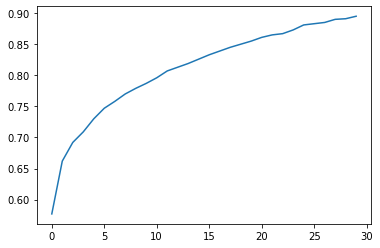

In [18]:
import matplotlib.pyplot as plt 

plt.plot(list(range(len(train_acc))), train_acc)
plt.show()

In [19]:
test_acc = run_network(model, op, loss, 1, test_iter, training=False)

  0%|                                                                                                                                                                                                         | 0/29 [00:00<?, ?it/s]D:\Miniconda3\envs\pytorch\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 45.23it/s, Epoch=1, Accuracy=0.771, Loss=0.488]